# Práctica 3: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2023__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RANDOM_STATE = 1234

# Apartado 1: Análisis de sentimientos

__Número de grupo: 1__

__Nombres de los estudiantes: Fernando Leal Isaías y Jinqing Cai__

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt

%matplotlib inline

## 1) Carga del conjunto de datos

> El fichero `IMBD_Dataset.csv` contiene opiniones de películas clasificadas en 2 categorías diferentes (positiva/negativa).

> Este set de datos se creó utilizando el "IMDB Dataset of 50K Movie Reviews", el cual contiene 50,000 reseñas de películas con un sentimiento positivo o negativo adjunto a ellas.

In [ ]:
imbd_file = '/content/drive/MyDrive/IA2/IMDB_Dataset.csv'

df = pd.read_csv(imbd_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



> Muestra un ejemplo de cada clase.

In [ ]:
# Hay dos clases: positivo o negativo
pd.concat(df[df.sentiment == sentiment].head(1) for sentiment in ("positive", "negative"))

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
3,Basically there's a family where a little boy ...,negative


> Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Lo primero, para contar el número de apariciones de una palabra en el conjunto de datos, pasamos a transformar nuestros documentos en bolsas de palabras. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
doc_word_freq = vectorizer.fit_transform(df.review)
doc_word_freq

<50000x101583 sparse matrix of type '<class 'numpy.int64'>'
	with 4434500 stored elements in Compressed Sparse Row format>

`vector_data` es ahora una matriz de $50,000 \times 101,583$ donde para cada review $r$ y cada palabra $i$ nos asocia el número de apariciones de $i$ en $r$

In [ ]:
#print([(i,count) for i in range(vector_data.shape[0]) if (count := vector_data[11,i]) > 0])
r = 11
i = 151
feature_names = vectorizer.get_feature_names_out()
feature_names[i], doc_word_freq[r,i]

('12', 2)

Esto nos dice que hay 2 apariciones de la palabra 151 (que se corresponde con el string `"12"`) en la review 11

In [ ]:
review_11 = df.loc[11].review
palabra_151 = feature_names[151]
review_11.count(palabra_151) == doc_word_freq[r,i]

True

Para sacar la palabra que aparece con más frecuencia, hacemos una **suma de las apariciones de cada palabra** en general, y buscamos aquella 

In [ ]:
def get_top_10_freq_words(vector_data):
    word_freq = np.squeeze(np.asarray(vector_data.sum(axis=0)))
    top_10_freq_words = word_freq.argsort()[::-1][:10]
    return top_10_freq_words, word_freq

In [ ]:
top_10_freq_words, word_freq = get_top_10_freq_words(doc_word_freq)
for top, word in enumerate(top_10_freq_words):
    print(f"Position {top + 1}: {feature_names[word]} with frequency {word_freq[word]}")

Position 1: br with frequency 201951
Position 2: movie with frequency 87971
Position 3: film with frequency 79705
Position 4: like with frequency 40172
Position 5: just with frequency 35184
Position 6: good with frequency 29753
Position 7: time with frequency 25110
Position 8: story with frequency 23119
Position 9: really with frequency 23094
Position 10: bad with frequency 18473


Aparece palabras como `br`, que es la etiqueta de HTML para hacer cambio de línea (normal que aparezca en nuestro dataset, pues es conjunto de reseñas de películas extraidas de una página web).

Por lo tanto, es necesario que hacer un preprocesamiento del dataset eliminando a estas palabras que no aportan ninguna información a la hora de clasificar los textos. 

Vamos a probar **normalizar** los documentos, y ver cómo cambia:

Para normalizar los documentos, quitamos todos los caracteres que no sean letras del abecedario o espacios, pasamos todo el texto a minúsculas y le quitamos los espacios de inicio y final. Una vez hecho esto, usamos el `WordPunctTokenizer` de `nltk` para separar los elementos por palabras, y hacemos un último filtro en el que quitamos palabras de la lista `stop_words`. Esta lista la hemos obtenido de `nltk` también, pero además hemos añadido `br`, puesto que no ofrece ninguna información semántica.

In [ ]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') + ['br']

@np.vectorize
def normalize_corpus(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Procedemos a aplicar la normalización descrita a las reseñas de nuestros datos

In [ ]:
normalized_reviews = normalize_corpus(df.review)

Y repetimos el estudio de las palabras más frecuentes que hicimos antes, pero con los documentos normalizados 

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
doc_word_freq = vectorizer.fit_transform(normalized_reviews)
feature_names = vectorizer.get_feature_names_out()
word_freq = np.squeeze(np.asarray(doc_word_freq.sum(axis=0)))

top_10_freq_words = word_freq.argsort()[::-1][:10]
for top, word in enumerate(top_10_freq_words):
    print(f"Position {top + 1}: {feature_names[word]} with frequency {word_freq[word]}")

Position 1: movie with frequency 83536
Position 2: film with frequency 74478
Position 3: like with frequency 39001
Position 4: good with frequency 28575
Position 5: time with frequency 23276
Position 6: really with frequency 22951
Position 7: story with frequency 22103
Position 8: great with frequency 17821
Position 9: bad with frequency 17720
Position 10: people with frequency 17542


Podemos observar que ahora las palabras más frecuentes son palabras que nos dan más información. Tiene sentido que `movie` y `film` sean las palabras más usadas, puesto que nuestro banco de datos son de reseñas de películas. También tiene sentido que aparezcan palabras como `like`, `good`, `great` o `bad`, pues la gente ha escrito las reseñas con la intención de compartir su opinión de las películas

**De ahora en adelante, usaremos el corpus normalizado**

In [ ]:
df2 = pd.DataFrame({"reviews": normalized_reviews, "sentiment": df.sentiment})
df_sin_normalizar = df
df = df2
df.head()

,reviews,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


> Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. Comprueba que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [ ]:
from sklearn.model_selection import train_test_split
train_reviews, test_reviews = train_test_split(df, test_size=0.2, train_size=0.8, random_state=RANDOM_STATE)

In [ ]:
# Veamos que tienen las mismas distribuciones
print(f"Número de casos en train set: {len(train_reviews)}")
print("Casos positivos: ", len(train_reviews[train_reviews["sentiment"] == "positive"]))
print("Casos negativos: ", len(train_reviews[train_reviews["sentiment"] == "negative"]))

print(f"Número de casos en test set: {len(test_reviews)}")
print("Casos positivos: ", len(test_reviews[test_reviews["sentiment"] == "positive"]))
print("Casos negativos: ", len(test_reviews[test_reviews["sentiment"] == "negative"]))

Número de casos en train set: 40000
Casos positivos:  19988
Casos negativos:  20012
Número de casos en test set: 10000
Casos positivos:  5012
Casos negativos:  4988


Se puede observar que la distribución de casos positivos y negativos es más o menos igual tanto en train set como en test set.

**De aquí adelante vamos a trabajar con el corpus normalizado.**

## 2) Estudio del efecto de distintas representaciones y distintos algoritmos para resolver la tarea

> Construye distintas representaciones vectoriales basadas en lo contado en las clases de teoría (bolsas de palabras con 2 configuraciones distintas significativas) y utilízalas con 2 de los algoritmos estudiados (árboles de decisión y naive bayes)

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

### Vector de frecuencias

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from types import SimpleNamespace
cv = SimpleNamespace()

cv.vectorizer = CountVectorizer(stop_words='english')
cv.train_preprocessed = cv.vectorizer.fit_transform(train_reviews.reviews)
cv.test_preprocessed = cv.vectorizer.transform(test_reviews.reviews)
cv.train_preprocessed.shape, cv.test_preprocessed.shape

((40000, 154793), (10000, 154793))

In [ ]:
# get all unique words in the corpus
vocab = cv.vectorizer.get_feature_names_out()
# show document feature vectors
pd.DataFrame.sparse.from_spmatrix(cv.train_preprocessed, columns=vocab)

,00,02,03,10,100,11,12,13,14,14th,...,zzvorkov,zzzz,zzzzip,zzzzzs,zzzzzzzz,zzzzzzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con esta información, intentamos resolver el problema usando 2 clasificadores: **árbol de decisión** y **clasificador de Naïve Bayes**. 

Podriamos usar también clasificador de K vecinos más cercanos con distancia euclídea. Sin embargo, no es una técnica adecuada para este tipo de problema al tener una gran cantidad de dimensiones (el número de palabras), y sufre de la maldición de la dimensionalidad. Sobre todo aquí donde la matriz es muy dispersa. Por lo tanto, sólo vamos a usar los dos clasificadores mencionados previamente.

#### Árbol de decisión

In [ ]:
# Creamos el clasificador con los valores por defecto
cv.tree_classifier = DecisionTreeClassifier().fit(cv.train_preprocessed, train_reviews.sentiment)

In [ ]:
cv.tree_train_predictions = cv.tree_classifier.predict(cv.train_preprocessed)
print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(cv.tree_train_predictions == train_reviews.sentiment))

Árbol, porcentaje de aciertos en entrenamiento: 1.0


In [ ]:
cv.tree_test_predictions = cv.tree_classifier.predict(cv.test_preprocessed)
print("Árbol, porcentaje de aciertos en test:", np.mean(cv.tree_test_predictions == test_reviews.sentiment))

Árbol, porcentaje de aciertos en test: 0.7345


El proceso del entrenamiento ha sido un largo (90s, ejecutado en la máquina de Google Colab). Clasifica ahora perfectamente los textos del conjunto de entrenamiento (1.0 de tasa de aciertos), y casi 73% de acierto en el conjunto de entrenamiento.

Veamos ahora cómo va el clasificador Naive Bayes:

#### Naive Bayes

Vamos a usar el clasificador **Naive Bayes Multinomial**. Porque es el que se utiliza cuando las variables son enteras (el número ed apariciones ed cada palabras en el review).

In [ ]:
cv.mnb_classifier = MultinomialNB()

cv.mnb_classifier.fit(cv.train_preprocessed, train_reviews.sentiment)

cv.mnb_train_predictions = cv.mnb_classifier.predict(cv.train_preprocessed)
cv.mnb_test_predictions = cv.mnb_classifier.predict(cv.test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(cv.mnb_train_predictions == train_reviews.sentiment))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(cv.mnb_test_predictions == test_reviews.sentiment))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.916475
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8509


Se puede observar que el proceso de entrenamiento ha sido mucho más rápido (menos de 1 segundo) con Naïve Bayes en comparación con el árbol de decisión anterior. La rápidez de Naive Bayes (una de sus principales características), se debe a que **asume que todas las variables son independientes entre sí**.

**La hipótesis anterior no es cierta en muchos casos**. En nuestro dataset, en un texto de sentimiento positivo es más probable que aparezca palabras con un significado positivo como "wonderful" o "great".

A pesar de eso, **el resultado que se ha obtenido ha sido mejor** que el de árbol de decisión. Por lo tanto, pensamos que a pesar de la asumpción errónea, este clasificador sigue siendo mejor para nuestro dataset.

### TF-IDF

Con los datos normalizados, ahora en `df`, usamos el `TfidVectorizer` para transformar cada review en un vector disperso, donde para una reseña `r` y una palabra `w` le asignamos su coeficiente TF-IDF, el cual se puede calcular de la siguiente forma:
$$
w_{r,i} = f_{r,i} \times \log\left(\frac{N}{f_i + 1}\right)
$$
donde $f_{r,i}$ representa la frecuencia de la palabra $i$ en la reseña $r$, $f_i$ representa la frecuencia de la palabra $i$ en todos los documentos en general, $N$ es el número de documentos.

`sklearn` no utiliza la misma fórmula, pero la propiedad principal de los coeficientes TF-IDF se mantiene tanto en la vista en teoría como la usada por `sklearn`: **da más importancia a términos con una alta frecuencia mayor de lo usual en el documento actual**, es decir, la frecuencia del término en el documento relacionado con la frecuencia del término en el corpus.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from types import SimpleNamespace
tfidf = SimpleNamespace()
tfidf.vectorizer = TfidfVectorizer().fit(train_reviews.reviews)

In [ ]:
tfidf.train  = tfidf.vectorizer.transform(train_reviews.reviews)
tfidf.test  = tfidf.vectorizer.transform(test_reviews.reviews)
tfidf.feature_names = tfidf.vectorizer.get_feature_names_out()

#### Árbol de decisión


Creamos un clasificador con un árbol de decisión, y lo entrenamos con los datos de entrenamiento previamente preparados.

In [ ]:
tfidf.tree = SimpleNamespace()
tfidf.tree.classifier = DecisionTreeClassifier().fit(tfidf.train, train_reviews.sentiment)

In [ ]:
tfidf.tree.train_pred = tfidf.tree.classifier.predict(tfidf.train)
print("Árbol, porcentaje de aciertos en train:", np.mean(tfidf.tree.train_pred == train_reviews.sentiment))

Árbol, porcentaje de aciertos en train: 1.0


In [ ]:
tfidf.tree.test_pred = tfidf.tree.classifier.predict(tfidf.test)
print("Árbol, porcentaje de aciertos en test:", np.mean(tfidf.tree.test_pred == test_reviews.sentiment))

Árbol, porcentaje de aciertos en test: 0.7143



#### Naive Bayes

In [ ]:
tfidf.nb = SimpleNamespace()
tfidf.nb.classifier = MultinomialNB().fit(tfidf.train, train_reviews.sentiment)

In [ ]:
tfidf.nb.train_pred = tfidf.nb.classifier.predict(tfidf.train)
print("Naive Bayes, porcentaje de aciertos en train:", np.mean(tfidf.nb.train_pred == train_reviews.sentiment))

Naive Bayes, porcentaje de aciertos en train: 0.9157


In [ ]:
tfidf.nb.test_pred = tfidf.nb.classifier.predict(tfidf.test)
print("Naive Bayes, porcentaje de aciertos en test:", np.mean(tfidf.nb.test_pred == test_reviews.sentiment))

Naive Bayes, porcentaje de aciertos en test: 0.8629


------------


> Para una única configuración, muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?
>
> **PREGUNTA** Que se eliminen o no palabras depende del paso de normalización, no del clasificador, no? 

Primero escogemos una reseña que visualizar. En nuestro caso, hemos elegido la número `10`, pues personalmente me pareció una reseña graciosa

In [ ]:
review_10 = df_sin_normalizar.loc[10, 'review']
print("Mensaje original:")
print('\n'.join(df_sin_normalizar.loc[10, 'review'].split('<br />')))

Mensaje original:
Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.

At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.

Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.

I imagine this film would appeal to a stoner who is currently partaking.

For something similar but better try "Brother from another planet"


La versión vectorizada del mensaje nos da menos información, pues la gran mayoría de palabras usadas en el corpus no se encuentran en esta reseña en específico:

In [ ]:
print("Mensaje vectorizado:")
review_vectorizada = tfidf.vectorizer.transform([df.loc[10,'reviews']]).toarray()
review_vectorizada_df = pd.DataFrame(review_vectorizada, columns = tfidf.feature_names)
review_vectorizada_df

Mensaje vectorizado:


,00,02,03,10,100,11,12,13,14,14th,...,zzvorkov,zzzz,zzzzip,zzzzzs,zzzzzzzz,zzzzzzzzz,zzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Podemos ver que palabras se han eliminado las siguientes palabras

In [ ]:
palabras_usadas = {word for word, tfidf in review_vectorizada_df.loc[0].items() if tfidf > 0}
palabras_eliminadas = [word for word in review_10.lower().split() if word not in palabras_usadas]
print(palabras_usadas)
print(palabras_eliminadas)

{'everything', 'didnt', 'thats', 'phil', 'appeal', 'planet', 'characters', 'interestbr', 'oddness', 'never', 'budget', 'interesting', 'actual', 'brother', 'jokes', 'something', 'movie', 'films', 'find', 'anymorebr', 'humour', 'similar', 'based', 'film', 'low', 'funny', 'odd', 'lost', 'one', 'pretty', 'rather', 'would', 'currently', 'better', 'quirky', 'alien', 'around', 'first', 'eventually', 'another', 'try', 'progressed', 'imagine', 'stoner', 'problem', 'punchlinesbr', 'partakingbr'}
['the', 'is', 'of', 'those', 'where', 'the', 'is', 'the', 'of', 'than', 'punchlines.<br', '/><br', '/>at', 'it', 'was', 'very', 'and', 'but', 'as', 'the', 'i', "didn't", 'the', 'or', 'anymore.<br', '/><br', '/>its', 'a', '(thats', 'a', 'in', 'itself),', 'there', 'were', 'some', 'characters,', 'but', 'i', 'just', 'interest.<br', '/><br', '/>i', 'this', 'to', 'a', 'who', 'is', 'partaking.<br', '/><br', '/>for', 'but', '"brother', 'from', 'planet"']


De las palabras eliminadas del review 10, podemos distinguir los siguientes tipos:

1. **Stopwords / Palabras vacías**: artículos, preposiciones, adverbios... que no aportan significado semántico a la hora de clasificar los textos. Por ejemplo, *the*, *is*, *of*.
2. **Palabras con caracteres especiales**: por ejemplo `punchlines.<br`

Notamos además que esta predicción fue correcta

In [ ]:
tfidf.tree.classifier.predict(review_vectorizada)

array(['negative'], dtype=object)

## 3) Análisis comparativo final

> Se han entrenado varios clasificadores usando vectorizaciones diferentes de los datos. Compara las diferencias entre representaciones para un mismo algoritmo y entre algoritmos. Explica a qué crees que se deben las diferencias.


Un resumen de los resultados obtenidos previamente:

In [ ]:
print("Vector de frecuencias, Árbol, porcentaje de aciertos en test:", np.mean(cv.tree_test_predictions == test_reviews.sentiment))
print("Vector de frecuencias, Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(cv.mnb_test_predictions == test_reviews.sentiment))
print("TF-IDF, Árbol, porcentaje de aciertos en test:", np.mean(tfidf.tree.test_pred == test_reviews.sentiment))
print("TF-IDF, Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(tfidf.nb.test_pred == test_reviews.sentiment))

Vector de frecuencias, Árbol, porcentaje de aciertos en test: 0.7345
Vector de frecuencias, Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8509
TF-IDF, Árbol, porcentaje de aciertos en test: 0.7143
TF-IDF, Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8629


Se puede observar que, independiente de la representación utilizada, las tasas de acierto de un mismo clasificador son casi iguales, con una diferencia de 1% como mucho.

La diferencia entre las dos representaciones es que el vector de frecuencias cuenta el número de apariciones de una palabra en un texto, sin hacer ningún tipo de tratamiento extra. Mientras que en TF-IDF, la **importancia de una palabra depende directamente de su frecuencia de aparición en el documento e inversamente a lo común que es en el corpus.**

La fórmula de TF-IDF era:

$$
w_{r,i} = f_{r,i} \times \log\left(\frac{N}{f_i + 1}\right)
$$

Como se ha obtenido un resultado muy parecido a la representación por vector de frecuencias, se debe a que $w_{r,i}$ es muy parecido al $f_{r,i}$ (la frecuencia de aparición del término $i$ en el documento $r$, es el contenido del vector de frecuencias). **Deducimos que $\log\left(\frac{N}{f_i + 1}\right)$ es un constante para todo $i$.**


> Analiza con detalle el mejor clasificador de cada tipo. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Tanto en vector de frecuencias como TF-IDF, el clasificador con mayor tasa de aciertos en el conjunto de test ha sido el **clasificador Naive Bayes multinomial. **

Vamos a calcular su rendimiento:

In [ ]:
print(classification_report(test_reviews.sentiment, cv.mnb_test_predictions))

              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      4988
    positive       0.87      0.83      0.85      5012

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Se puede observar que la métrica para las dos clases son muy parecidas (precisión, recall y F1), cercanos al 0.85.

Veamos su **matriz de confusión.**

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_reviews.sentiment, cv.mnb_test_predictions)

In [ ]:
conf_matrix

array([[4357,  631],
       [ 860, 4152]])

(array([0.5, 1.5]), [Text(0.5, 0, 'negative'), Text(1.5, 0, 'positive')])

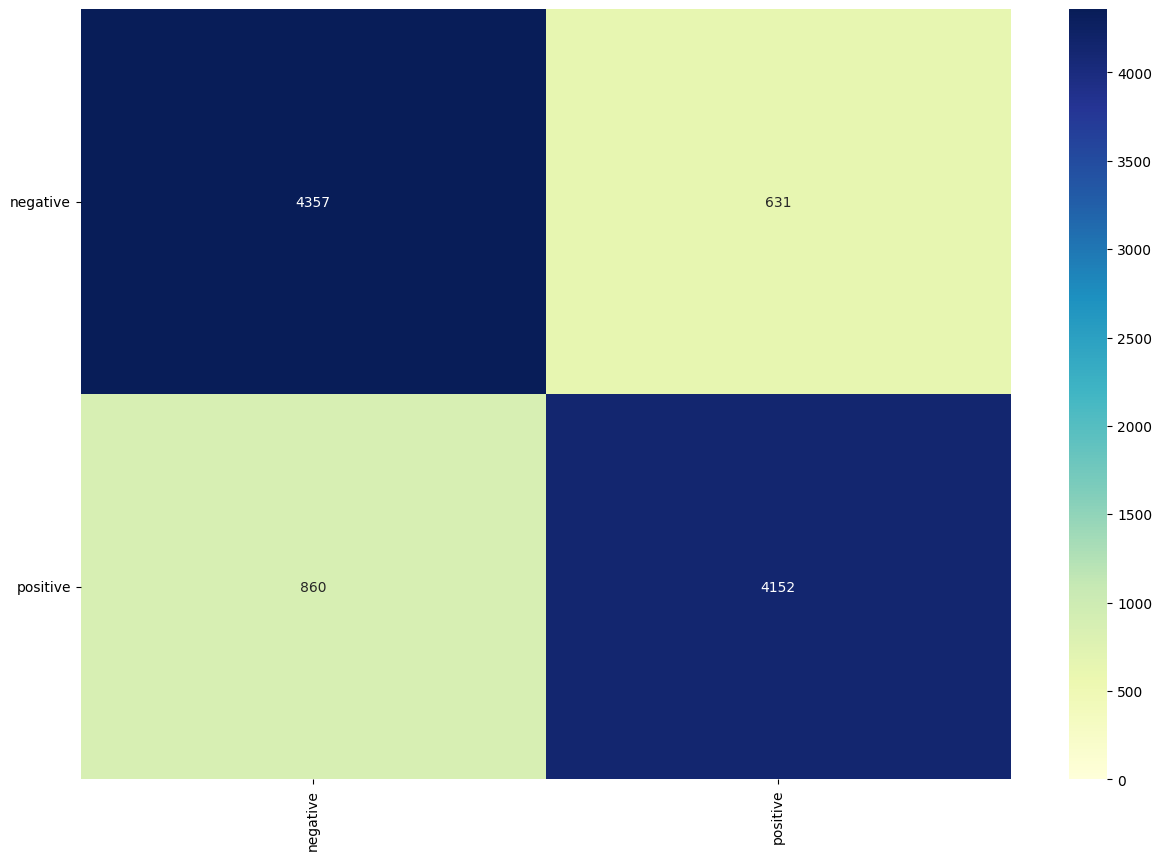

In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix, index=("negative", "positive"), columns=("negative", "positive"))

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

> Indica las palabras más relevantes.

Extraemos las palabras más relevantes de cada clase:

In [ ]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [ ]:
print_top20_features_per_class_in_NB(cv.vectorizer, cv.mnb_classifier, test_reviews.sentiment.unique())       

Top 20 features per class

negative: movie / film / like / bad / good / really / time / dont / story / people / make / movies / acting / plot / characters / way / watch / think / films / know 

positive: film / movie / like / good / great / story / time / really / people / love / films / best / way / life / characters / think / movies / dont / seen / character 



La verdad es que **no hay palabras muy significativas que permite distinguir una clase de la otra**. Quizá esa es la razón por la cual el clasificador de árbol no funciona tan bien.

Para solucionar este problema, como nuestro dataset son reviews de películas, **deberíamos descartar palabras específicos de este dominio**, como por ejemplo *movie*. Con eso, le daríamos importancia a otras palabras menos frecuentes, y quizá clasifica mejor.

> Busca un ejemplo mal clasificado de cada clase, justifica el error ¿se te ocurre alguna forma de solucionarlo?

Vamos a extrar ejemplos mal clasificados:

In [ ]:
wrong = [(review, prediction) for review, prediction, sentiment in zip(test_reviews.reviews, cv.mnb_test_predictions, test_reviews.sentiment) if prediction != sentiment]

# Textos clasificada como positive cuando no lo es
falsePositive = [review for review, prediction in wrong if prediction == "positive"]

# Textos clasificada como negative cuando no lo es
falseNegative = [review for review, prediction in wrong if prediction == "negative"]

In [ ]:
print("Un ejemplo de falso positivo: ")
print(falsePositive[0])

Un ejemplo de falso positivo: 
although film made dogme emerged predominant method filmmaking digital triumphed strike get point masterpiece clearly anticipated developments corin nemec outstanding neer well author narrator pace slow elegantly cinematography beautiful record next time tv guarantee youll never see better nostalgia ripoff madefor tv movie directtovideo never felt good


In [ ]:
print("Un ejemplo de falso negativo: ")
print(falseNegative[0])

Un ejemplo de falso negativo: 
nothing new tired seriocomedy wastes talents danny glover whoopi goldberg considering produced stars spike lee pretty tame tired stuff come whoop never changes hair glasses many years film covers blah


Como había comentado anteriormente, una forma de mejorar la clasificación viendo las palabras más utilizadas sería introducir un diccionario con las palabras frecuentes de nuestro dominio de reseña de películas, y eliminar esas palabras del corpus durante el proceso de normalización.